In [ ]:
'import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle/"

In [ ]:
%cd /content/drive/My Drive/kaggle/


/content/drive/My Drive/kaggle


In [ ]:
!kaggle datasets download -d ming666/flicker8k-dataset

100% 2.07G/2.08G [00:35<00:00, 54.3MB/s]
100% 2.08G/2.08G [00:35<00:00, 62.6MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k_dataset/Flicker8k_Dataset/2847514745_9a35493023.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2847615962_c330bded6e.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848266893_9693c66275.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848571082_26454cb981.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848895544_6d06210e9d.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848977044_446a31d86e.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2849194983_2968c72832.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2850719435_221f15e951.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2851198725_37b6027625.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2851931813_eaf8ed7be3.jpg  
  inflating: flickr8k_dataset/Flicker

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

In [ ]:
pip install -q pyyaml h5py 

In [ ]:
images_dir = os.listdir("/content/drive/My Drive/kaggle/")

images_path = '/content/drive/My Drive/kaggle/flickr8k_dataset/Flicker8k_Dataset/'
captions_path = '/content/drive/My Drive/kaggle/Flickr8k_text/Flickr8k.token.txt'
train_path = '/content/drive/My Drive/kaggle/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = '/content/drive/My Drive/kaggle/Flickr8k_text/Flickr_8k.devImages.txt'
test_path = '/content/drive/My Drive/kaggle/Flickr8k_text/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

In [ ]:
temp = captions[15].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])


NameError: ignored

In [ ]:
train_dataset = open('/content/drive/My Drive/kaggle/flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('/content/drive/My Drive/kaggle/flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('/content/drive/My Drive/kaggle/flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")


18

In [ ]:
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

NameError: ignored

In [ ]:
#f=open('/content/drive/My Drive/kaggle/flickr_8k_train_dataset.txt','r')
#for data in f:
  #print(data)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
train_data = {} #no need to run this column again& again
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred


1000
2000
3000


In [ ]:
val_data = {} #no need to run this column again& again
ctr=0
for ix in x_val:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    val_data[ix] = pred

1000


In [ ]:
val_data['327621377_0bc3b7fd26.jpg'].shape

(2048,)

In [ ]:
0with open( "/content/drive/My Drive/kaggle/train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f ) 

In [ ]:
with open( "/content/drive/My Drive/kaggle/val_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(val_data, pickle_f ) 

In [ ]:
pd_dataset = pd.read_csv("/content/drive/My Drive/kaggleP/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [ ]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [ ]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [ ]:
sentences[:5]


['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [ ]:
words = [i.split() for i in sentences]
#for data in words:
  #print(data)

In [ ]:
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [ ]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [ ]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253


In [ ]:
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [ ]:
#print(word_2_indices['<start>'])
#print(indices_2_word[4011])
#print(word_2_indices['<end>'])
#print(indices_2_word[8253])

In [ ]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [ ]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)


print(max_len)

40


In [ ]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
          
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)


(30000,)
(30000,)


In [ ]:
print(len(padded_sequences[0]))


19


In [ ]:
for ix in range(len(padded_sequences[0])):
    for iy in ranege(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")
    
print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
the
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
the
boy
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
the
boy
laying
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
the
boy
laying
face
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
the
boy
laying
face
down
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UN

In [ ]:
num_of_images = 2000

In [ ]:
captions_val = np.zeros([0, max_len])
next_words_val = np.zeros([0, vocab_size])

In [ ]:
#no need to run this 
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]): 
    captions_val = np.concatenate([captions_val, padded_sequences[ix]])
    next_words_val = np.concatenate([next_words_val, subsequent_words[ix]])

np.save("/content/drive/My Drive/kaggle/captions_val.npy", captions_val)
np.save("/content/drive/My Drive/kaggle/next_words_val.npy", next_words_val)

print(captions_val.shape)
print(next_words_val.shape)

(12833, 40)
(12833, 8254)


In [ ]:
print(captions_val.shape)
print(next_words_val.shape)

(12833, 40)
(12833, 8254)


In [ ]:
with open('/content/drive/My Drive/kaggle/train_encoded_images.p', 'rb') as f:
    val_encoded_images = pickle.load(f, encoding="bytes")
print(val_encoded_images)

{'2513260012_03d33305cf.jpg': array([0.30808437, 0.81291294, 0.2841724 , ..., 0.25810236, 0.        ,
       0.2185827 ], dtype=float32), '2903617548_d3e38d7f88.jpg': array([0.0346456 , 0.61849904, 0.00202973, ..., 0.        , 0.0528223 ,
       0.65297943], dtype=float32), '3338291921_fe7ae0c8f8.jpg': array([1.6495912e+00, 1.4456929e+00, 2.5820368e-04, ..., 0.0000000e+00,
       7.2089336e-03, 1.8084404e-01], dtype=float32), '488416045_1c6d903fe0.jpg': array([0.1711663 , 0.8935701 , 0.06174025, ..., 0.06140478, 0.2930055 ,
       0.2800498 ], dtype=float32), '2644326817_8f45080b87.jpg': array([0.23051299, 1.529338  , 0.00789333, ..., 0.        , 0.48846728,
       0.1731161 ], dtype=float32), '218342358_1755a9cce1.jpg': array([0.77619475, 0.2842749 , 0.50556344, ..., 0.6218707 , 0.22369894,
       0.0520548 ], dtype=float32), '2501968935_02f2cd8079.jpg': array([0.5506613 , 2.192281  , 0.17906244, ..., 0.00408255, 0.36933827,
       0.5891118 ], dtype=float32), '2699342860_5288e203ea.j

In [ ]:
#for data in val_encoded_images:
  #print(data)

In [ ]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in val_encoded_images.keys():
        #print("i'm inside")
        #print(ix, encoded_images[ds[ix, 0]])
        imgs.append(list(val_encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(5000, 2048)


In [ ]:
val_images = [] # no need

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        val_images.append(imgs[ix])
        
val_images = np.asarray(val_images)

np.save("/content/drive/My Drive/kaggle/val_images.npy", val_images)

print(val_images.shape)

(12833, 2048)


In [ ]:
val_image_names = [] #no need

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        val_image_names.append(ds[ix, 0])
        
val_image_names = np.asarray(val_image_names)

np.save("/content/drive/My Drive/kaggle/val_image_names.npy", val_image_names)

print(len(val_image_names))

12833


In [ ]:
val_captions = np.load("/content/drive/My Drive/kaggle/captions_val.npy")
val_next_words = np.load("/content/drive/My Drive/kaggle/next_words_val.npy")

print(val_captions.shape)
print(val_next_words.shape)

(12833, 40)
(12833, 8254)


In [ ]:
val_images = np.load("/content/drive/My Drive/kaggle/val_images.npy")

print(val_images.shape)

(12833, 2048)


In [ ]:
val_imag = np.load("/content/drive/My Drive/kaggle/val_image_names.npy")
        
print(val_imag.shape)

(12833,)


In [ ]:
captions = np.load("/content/drive/My Drive/kaggle/captions.npy")
next_words = np.load("/content/drive/My Drive/kaggle/next_words.npy")

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [ ]:
images = np.load("/content/drive/My Drive/kaggle/images.npy")

print(images.shape)

(25493, 2048)


In [ ]:
imag = np.load("/content/drive/My Drive/kaggle/image_names.npy")
        
print(imag.shape)

(25493,)


In [ ]:
imag = np.load("/content/drive/My Drive/kaggle/train_encoded_images.p")
        
print(imag)

In [ ]:
embedding_size = 128
max_len = 40

In [ ]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           1056512   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)



# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1056512     embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
_______________________________________________________________________________________

In [ ]:
hist = model.fit([images, captions], next_words, batch_size=100, epochs=10, validation_data=([val_images,val_captions], val_next_words))

Epoch 1/10
255/255 [==============================] - 11s 42ms/step - loss: 1.7544 - accuracy: 0.5166 - val_loss: 17.4108 - val_accuracy: 0.0017
Epoch 2/10
255/255 [==============================] - 10s 41ms/step - loss: 1.9017 - accuracy: 0.5096 - val_loss: 16.7561 - val_accuracy: 3.8962e-04
Epoch 3/10
255/255 [==============================] - 11s 42ms/step - loss: 1.9762 - accuracy: 0.5037 - val_loss: 16.6958 - val_accuracy: 0.0016
Epoch 4/10
255/255 [==============================] - 11s 42ms/step - loss: 1.9857 - accuracy: 0.5115 - val_loss: 16.9216 - val_accuracy: 0.0018
Epoch 5/10
255/255 [==============================] - 11s 41ms/step - loss: 2.0174 - accuracy: 0.5127 - val_loss: 16.5080 - val_accuracy: 0.0019
Epoch 6/10
255/255 [==============================] - 10s 41ms/step - loss: 2.0330 - accuracy: 0.5119 - val_loss: 16.4882 - val_accuracy: 0.0021
Epoch 7/10
255/255 [==============================] - 11s 41ms/step - loss: 2.0230 - accuracy: 0.5188 - val_loss: 16.4710 - va

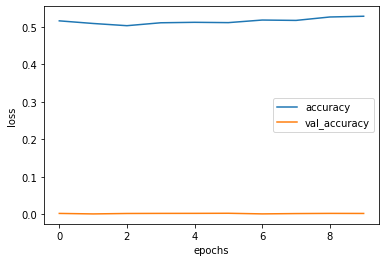

In [ ]:
for label in ["accuracy","val_accuracy"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

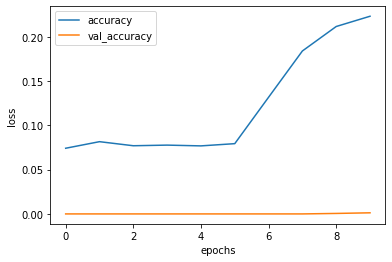

In [ ]:
for label in ["accuracy","val_accuracy"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
hist_val = model.fit([val_images, captions_val], next_words_val, batch_size=512, epochs=10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200
12833/12833 [==============================] - 7s 557us/step - loss: 5.6371 - accuracy: 0.0701
Epoch 2/200
12833/12833 [==============================] - 6s 460us/step - loss: 5.2164 - accuracy: 0.0852
Epoch 3/200
12833/12833 [==============================] - 6s 464us/step - loss: 5.2261 - accuracy: 0.0760
Epoch 4/200
12833/12833 [==============================] - 6s 465us/step - loss: 5.1825 - accuracy: 0.0812
Epoch 5/200
12833/12833 [==============================] - 6s 468us/step - loss: 4.9685 - accuracy: 0.1145
Epoch 6/200
12833/12833 [==============================] - 6s 466us/step - loss: 5.0860 - accuracy: 0.0805
Epoch 7/200
12833/12833 [==============================] - 6s 475us/step - loss: 4.8943 - accuracy: 0.1068
Epoch 8/200
12833/12833 [==============================] - 6s 470us/step - loss: 4.7927 - accuracy: 0.1175
Epoch 9/200
12833/12833 [==============================] - 6s 472us/step - loss: 4.8502 - accuracy: 0.1056
Epoch 10/200
12833/12833 [===========

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/kaggle/model_val.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/kaggle/model_val.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
f=open('/content/drive/My Drive/kaggleP/model.json','r')
for data in f:
  print(data)

{"class_name": "Model", "config": {"name": "model_1", "layers": [{"name": "embedding_1_input", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 40], "dtype": "float32", "sparse": false, "name": "embedding_1_input"}, "inbound_nodes": []}, {"name": "dense_1_input", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 2048], "dtype": "float32", "sparse": false, "name": "dense_1_input"}, "inbound_nodes": []}, {"name": "embedding_1", "class_name": "Embedding", "config": {"name": "embedding_1", "trainable": true, "batch_input_shape": [null, 40], "dtype": "float32", "input_dim": 8254, "output_dim": 128, "embeddings_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "embeddings_regularizer": null, "activity_regularizer": null, "embeddings_constraint": null, "mask_zero": false, "input_length": 40}, "inbound_nodes": [[["embedding_1_input", 0, 0, {}]]]}, {"name": "dense_1", "class_name": "Dense", "config": {"na

In [ ]:

model.load_weights('/content/drive/My Drive/kaggle/modelF.h5')

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics = ['accuracy'])
#hist = model.fit([images, captions], next_words, batch_size=512, epochs=1)


In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [ ]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [ ]:
img = "/content/drive/My Drive/kaggleP/flickr8k_dataset/Flicker8k_Dataset/1453366750_6e8cf601bf.jpg"
test_img = get_encoding(resnet, img)

In [ ]:

def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

In [ ]:
def greedySearch(image):
    in_text = '<start>'
    for i in range(max_len):
        par_caps = [word_2_indices[w] for w in in_text.split() if w in word_2_indices]
        par_caps=sequence.pad_sequences([par_caps], maxlen=max_len)
        yhat = model.predict([np.array([image]), np.array(par_caps)], verbose=0)
        yhat = np.argmax(yhat)
        word = indices_2_word[yhat]
        in_text += ' ' + word
        if word == '<end>':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final
Argmax_Search = greedySearch(test_img)   

In [ ]:
#f=open('/content/drive/My Drive/kaggle/flickr_8k_test_dataset.txt','r')
#for data in f:
  #print(data)

In [ ]:
 
  
# Output img with window name as 'image' 
from IPython.display import Image  
z = Image(filename=img)
display(z) 

print(Argmax_Search)
hypothesis= Argmax_Search.split()
reference  = " Two children are shown upside down ."
references = [reference.split()] 
from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))                       